<a href="https://colab.research.google.com/github/olexandr7/erm_workshop/blob/main/ERM_workshop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all, let's take a look at how data is represented in RDF format

In [ ]:
#https://opendata.muis.ee/

#installing rdflib library
%pip install rdflib

#https://rdflib.readthedocs.io/en/stable/gettingstarted.html#a-more-extensive-example
from rdflib import Graph
#downloading files from Colab
from google.colab import files

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Create a Graph
g = Graph()

# Parse in an RDF file hosted on the Internet
g.parse("http://opendata.muis.ee/object/1203128")
#g.parse("http://opendata.muis.ee/object/1120182")

# Print out the entire Graph in the RDF Turtle format
#print(g.serialize(format='turtle'))

for s, p, o in g:
    print(s, p, o)
    #examples of possible filters
    #if "image/" in o: print(s)
    #if "P46_is_composed_of" in p: print(o)

In [ ]:
####
# Textile collection analysis
####

#http://www.muis.ee/rdf/collection/837
#https://www.muis.ee/museaalview/1887998
#textile collection (Muuseumikogu tekstiil) from Tallinna Linnamuuseum

#idea
#getting list of all objects from collection into list
#getting descriptions from each of objects into dataframe

In [3]:
g = Graph()
collectionitemslist = []

# Parse in an RDF file
#g.parse("http://www.muis.ee/rdf/collection/831")
g.parse("http://www.muis.ee/rdf/collection/849")

#loop through triples
for s, p, o in g:
    if "P46_is_composed_of" in p: collectionitemslist.append(o)

#collectionitemslist now contains urls of all items in this particular collection

In [ ]:
#displaying the output
collectionitemslist

In [ ]:
#Generating dataset for Wordcloud

#filtering out values from valid URLs, adding them into two lists
collectionitemslist_url = []
collectionitemslist_title = []

it = 0

for i in collectionitemslist:
    g = Graph()
    try:
        it += 1
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(o), print ('-------'), print(it), collectionitemslist_url.append(i), collectionitemslist_title.append(o)
    except:
        pass

In [ ]:
#making dataframe out of lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title)))
df = df.rename(columns={0: 'URL', 1: 'Title'})
df

In [8]:
#Creating wordcloud based on example from:
#https://github.com/amueller/word_cloud/blob/main/examples/simple.py

#additional filtering could be applied if needed
#df = df[df['Label'].str.contains("Kleit")]
#creating a single string with all values from identifier column
df_joined = ' '.join(df['Title'].to_list())

#would actually also need to do some: cleansing, lemmisation, tokenisation

In [9]:
df_joined

'Silikaattellis Katusekivi nn munkkivi Katusekivi nn nunnkivi Katusekivi nn munkkivi Tellis Tellis Tellis Katusekivi, harjakivi Katusekivi, harjakivi Tellis Tellis Tellis Katusekivi, nn nunnkivi fragment Lintkivi Tuhkliivkivi tellis Fassaadi tellis Katusekivi nn munkkivi Tellis Katusekivi, fragment Katusekivi nn nunnkivi Tellis Tellis Tellis Katusekivi nn nunnkivi Tellis Katusekivi nn munkkivi Tellis Katusekivi nn munkkivi Tellis Katusekivi nn munkkivi Katusekivi nn nunnkivi Tellis Tellis Tellis Tellis Kärgtellis Katusekivi nn munkkivi Katusekivi nn  munkkivi Silikaatkivi Kärgtellis Katusekivi nn munkkivi Tellis Katusekivi, harjakivi Silikaattellis Katusekivi Katusekivi, harjakivi Katusekivi nn munkkivi Tellis Katusekivi nn munkkivi Tellis Tuhkliivkivi tellis Katusekivi Katusekivi nn munkkivi Katusekivi nn nunnkivi Tellis Tellis Vahtsilikatsiit vaheplaat-tellis Katusekivi nn nunnkivi Tellis, poolik Katusekivi nn nunnkivi Katusekivi, harjakivi Tellis Tellis, poolik Tellis Katusekivi Tel

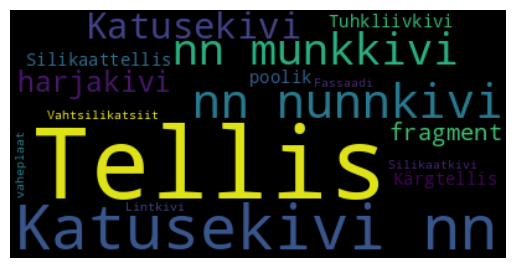

In [10]:
#generating world cloud

# lower max_font_size
wordcloud = WordCloud(max_font_size=80).generate(df_joined)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Let's now look into exporting MuIS content into Excel file

In [ ]:
#filtering out values from valid URLs, adding them into multiple lists
collectionitemslist_url = []
collectionitemslist_title = []
collectionitemslist_label = []
collectionitemslist_availabiletime = []
collectionitemslist_identifier = []
collectionitemslist_publisher = []
collectionitemslist_collection = []
it = 0

for i in collectionitemslist:
    g = Graph()
    try:
        it += 1
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_title.append(o)
            if "purl.org/dc/terms/available" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_availabiletime.append(o)
            if "purl.org/dc/terms/identifier" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_identifier.append(o)
            if "purl.org/dc/elements/1.1/publisher" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_publisher.append(o)
            if "http://opendata.muis.ee/object/" in s and "cidoc-crm/P46i_forms_part_of" in p and "/collection/" in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_collection.append(o)
            if "rdf-schema#label" in p and "tervik" not in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_label.append(o)
    except:
        pass

In [ ]:
#making dataframe out of lists
# import pandas as pd
import pandas as pd

df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title, collectionitemslist_label,
                           collectionitemslist_availabiletime, collectionitemslist_identifier, collectionitemslist_publisher, collectionitemslist_collection)))
df = df.rename(columns={0: 'URL',1: 'Title', 2: 'Label', 3: 'Made available', 4: 'Identifier', 5: 'Publisher', 6: 'Collection'})
#df = df[df['Label'].str.contains("tervik") == False]  #filtering out values with "tervik"

In [ ]:
#file export out
df.to_excel("labels.xlsx")

#downloading file from browser
files.download('labels.xlsx')